In [1]:
from pathlib import Path

import numpy as np
import tensorflow as tf
import keras_cv
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

2024-11-19 08:04:31.268097: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-19 08:04:31.269108: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-19 08:04:31.308334: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-19 08:04:31.460415: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-19 08:04:32.202214: W tensorflow/compiler/tf2tensorrt/utils/py_uti

In [2]:
SEED = 42
DATA_DIR = Path().absolute().parent / "data"
DATA_PATH = DATA_DIR / "training_set.npz"
OUTPUT_DIR = DATA_DIR / "augmented"

In [3]:
RNG = np.random.default_rng(SEED)

In [4]:
with np.load(DATA_PATH) as data:
    images: np.ndarray = data["images"]
    labels: np.ndarray = data["labels"]

print(images.shape)
print(labels.shape)

(13759, 96, 96, 3)
(13759, 1)


## Cleaning

In [5]:
image_means: np.ndarray = images.mean(axis=(1, 2, 3))

In [6]:
TOLERANCE = 1e-4
MIN_DUPLICATES = 5

mean_indices = {}
for mean in image_means:
    indices = (np.abs(mean - image_means) <= TOLERANCE).nonzero()[0]
    if len(indices) > MIN_DUPLICATES:
        mean_indices[mean] = indices

len(mean_indices.keys())

2

In [7]:
duplicated_indices = []
for indices in mean_indices.values():
    duplicated_indices.extend(indices)
duplicated_indices = np.array(duplicated_indices)
duplicated_indices.shape

(1800,)

In [8]:
original_indices = np.setdiff1d(
    list(range(images.shape[0])),
    duplicated_indices
)
original_indices.shape

(11959,)

In [9]:
clean_images = images[original_indices]
clean_labels = labels[original_indices]

print(clean_images.shape)
print(clean_labels.shape)

(11959, 96, 96, 3)
(11959, 1)


## Rebalance

In [10]:
unique_labels, counts = np.unique(clean_labels, return_counts=True)
count_proportion = counts / counts.max()
sample_proportion = 1 / count_proportion
sample_proportion

array([2.73474178, 1.06831729, 2.14746544, 1.15004936, 2.74440518,
       2.34642497, 1.        , 1.41813755])

In [11]:
rebalanced_image_list = []
rebalanced_label_list = []
for label, count, proportion in zip(np.unique(clean_labels), counts, sample_proportion):
    label_support = np.nonzero(clean_labels == label)[0]
    i = RNG.choice(label_support, int(np.round(count * proportion)))
    rebalanced_image_list.append(clean_images[i])
    rebalanced_label_list.append(clean_labels[i])

In [12]:
rebalanced_images = np.concatenate(rebalanced_image_list, axis=0)
rebalanced_labels = np.concatenate(rebalanced_label_list, axis=0)

print(rebalanced_images.shape)
print(rebalanced_labels.shape)

(18640, 96, 96, 3)
(18640, 1)


## Validation split

In [13]:
images_train, images_val, labels_train, labels_val = train_test_split(
    rebalanced_images, rebalanced_labels,
    test_size=.15,
    random_state=42,
    stratify=rebalanced_labels,
)

print(images_train.shape)
print(labels_train.shape)

print(images_val.shape)
print(labels_val.shape)

(15844, 96, 96, 3)
(15844, 1)
(2796, 96, 96, 3)
(2796, 1)


## Augmentation

In [14]:
def augment(dataset: tf.data.Dataset) -> tf.Tensor:
    pipeline = keras_cv.layers.RandomAugmentationPipeline(
        layers=[
            keras_cv.layers.RandomTranslation((0.3, 0.4), (0.3, 0.4), fill_mode="wrap"),
            keras_cv.layers.RandomRotation(1.0, fill_mode="wrap"),
            keras_cv.layers.RandomChannelShift(value_range=(0, 255), factor=(0.3, 0.5)),
            keras_cv.layers.RandomHue((0.3, 0.5), (0, 255)),
            keras_cv.layers.RandomBrightness((-0.4, -0.3)),
        ],
        augmentations_per_image=2,
        rate=1.0,
        auto_vectorize=True,
    )

    return pipeline(dataset)

In [15]:
def one_hot_encode(x, y, num_classes=8):
    return (
        x,
        tf.reshape(
            tf.cast(to_categorical(y, num_classes=num_classes), tf.uint8),
            [-1],
        )
    )

In [16]:
augmented_images_train: np.ndarray = np.concatenate([
    images_train,
    augment(images_train).numpy(),
]) / 255.0
augmented_labels_train = np.concatenate([labels_train, labels_train])
augmented_images_val: np.ndarray = np.concatenate([
    images_val,
    augment(images_val).numpy(),
]) / 255.0
augmented_labels_val = np.concatenate([labels_val, labels_val])

print(augmented_images_train.shape)
print(augmented_labels_train.shape)

INFO:tensorflow:Running stacked flow
INFO:tensorflow:Running stacked flow
INFO:tensorflow:Running stacked flow
INFO:tensorflow:Running stacked flow
(31688, 96, 96, 3)
(31688, 1)


In [17]:
augmented_train_dataset = (
    tf.data.Dataset.from_tensor_slices((augmented_images_train, augmented_labels_train))
    .map(one_hot_encode, num_parallel_calls=tf.data.AUTOTUNE)
)
augmented_train_dataset = augmented_train_dataset.shuffle(augmented_train_dataset.cardinality())
augmented_train_dataset.save(str(OUTPUT_DIR / "train"))

augmented_val_dataset = (
    tf.data.Dataset.from_tensor_slices((augmented_images_val, augmented_labels_val))
    .map(one_hot_encode, num_parallel_calls=tf.data.AUTOTUNE)
)
augmented_val_dataset = augmented_val_dataset.shuffle(augmented_val_dataset.cardinality())
augmented_val_dataset.save(str(OUTPUT_DIR / "val"))

## Analysis

In [18]:
augmented_train_dataset = tf.data.Dataset.load(str(OUTPUT_DIR / "train"))
augmented_val_dataset = tf.data.Dataset.load(str(OUTPUT_DIR / "val"))

In [19]:
augmented_train_dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(96, 96, 3), dtype=tf.float32, name=None), TensorSpec(shape=(8,), dtype=tf.uint8, name=None))>

In [20]:
len([sample for sample in augmented_train_dataset])

2024-11-19 08:05:05.617464: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


31688

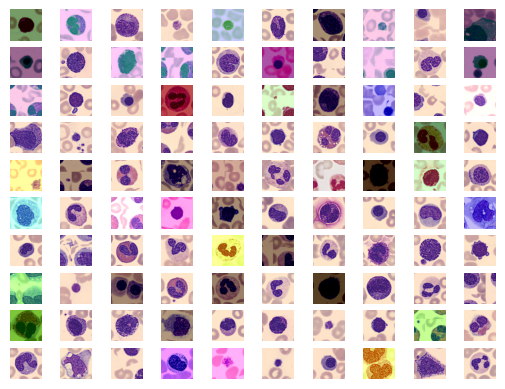

In [21]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=10, ncols=10)
axes = axes.reshape((-1))

for ax, (image, _) in zip(axes, augmented_train_dataset.as_numpy_iterator()):
    ax.set_axis_off()
    ax.imshow(image)